In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import OrderedDict
import plotly.graph_objects as go

from trainer import Trainer

# Generate data

In [2]:
X = torch.linspace(-torch.pi, torch.pi, 100)
Y = torch.sin(X) + torch.normal(mean=0, std=torch.full(X.shape, 0.05))
tr_data = torch.stack([X, Y], dim=1)

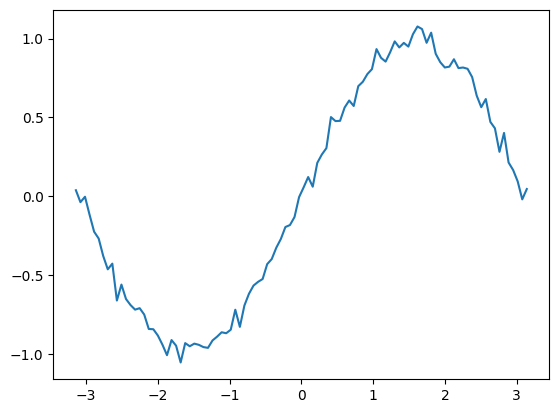

In [3]:
plt.plot(X, Y)
plt.show()

# Model

In [4]:
class SimpleModel(nn.Module):
    """
    Simple model for testing
    """
    def __init__(self, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                                 nn.LazyLinear(4), nn.ReLU(),
                                 )
        self.last_proj = nn.LazyLinear(output_dim)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.last_proj(self.net(X))

    def loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        loss_fn = nn.MSELoss()
        return loss_fn(y_hat, y)

In [5]:
model=SimpleModel(output_dim=1)

/Users/dmitripedchenko/miniconda3/envs/loss_func/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


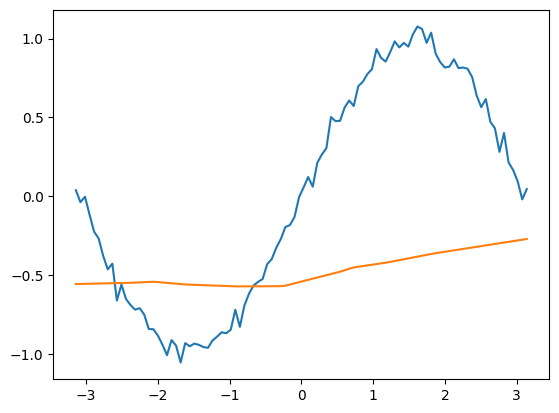

In [6]:
plt.plot(X,Y)
plt.plot(X, model(X.reshape(-1, 1)).detach())
plt.show()

Train

In [7]:
trainer = Trainer(train_epochs=10_000, lr = 0.1)

In [8]:
trainer.train(model, tr_data, print_epoch=1_000)

Training epoch 0
Training epoch 1000
Training epoch 2000
Training epoch 3000
Training epoch 4000
Training epoch 5000
Training epoch 6000
Training epoch 7000
Training epoch 8000
Training epoch 9000


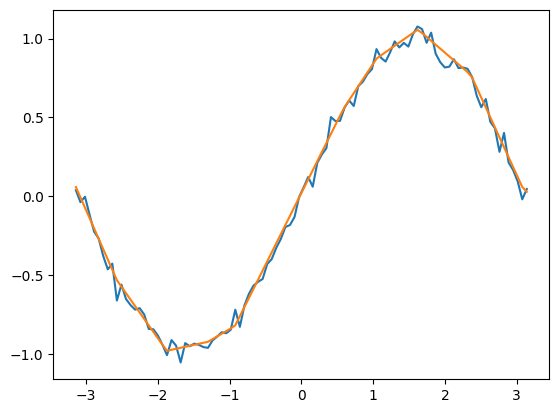

In [9]:
plt.plot(X,Y)
plt.plot(X, model(X.reshape(-1, 1)).detach())
plt.show()

# Plot of loss function as the function of model parameters

## Plot function along a direction vector in param space

In [10]:
model.eval()
trained_weights = model.state_dict()
trained_weights

OrderedDict([('net.0.weight',
              tensor([[-0.2943],
                      [ 0.2366],
                      [ 0.8422],
                      [ 0.2380],
                      [-0.7767],
                      [ 0.6569],
                      [ 0.3537],
                      [ 0.3826]])),
             ('net.0.bias',
              tensor([-0.7557,  0.3078, -1.3683, -0.8527, -0.7187, -0.6906,  0.6622,  0.7190])),
             ('net.2.weight',
              tensor([[-0.3943, -0.3754,  0.0886, -0.2930, -0.2886, -0.0209, -0.2629, -0.2147],
                      [ 0.4390, -0.0271, -0.4429, -0.1065,  0.1130,  0.0325,  0.2366,  0.1971],
                      [-0.2903, -0.2026, -0.3427,  0.3422, -0.1898, -0.0767, -0.3754, -0.1113],
                      [ 0.5490,  0.1903, -1.0902, -0.1553,  0.3550, -0.6796,  0.4501,  0.5380]])),
             ('net.2.bias', tensor([ 0.5997, -0.0801,  1.1975,  0.2612])),
             ('last_proj.weight',
              tensor([[-0.8381,  0.3436, -1.0709,  0

Randomly init direction vector

In [11]:
dir_vec = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)
dir_vec

OrderedDict([('net.0.weight',
              tensor([[-0.0103],
                      [-0.0010],
                      [-0.0031],
                      [ 0.0025],
                      [-0.0057],
                      [ 0.0060],
                      [-0.0206],
                      [ 0.0105]])),
             ('net.0.bias',
              tensor([ 0.0059,  0.0063,  0.0164, -0.0042,  0.0013,  0.0113, -0.0037,  0.0023])),
             ('net.2.weight',
              tensor([[ 0.0058,  0.0247,  0.0011, -0.0095, -0.0019, -0.0013,  0.0061, -0.0015],
                      [ 0.0075,  0.0111,  0.0092,  0.0087, -0.0150, -0.0029, -0.0115, -0.0027],
                      [ 0.0126,  0.0024,  0.0116,  0.0015, -0.0026, -0.0067,  0.0163, -0.0085],
                      [-0.0008, -0.0064,  0.0089,  0.0050, -0.0113,  0.0098, -0.0005, -0.0025]])),
             ('net.2.bias', tensor([ 0.0093,  0.0050,  0.0228, -0.0093])),
             ('last_proj.weight',
              tensor([[-0.0055, -0.0010, -0.0090, -0

In [14]:
line_param =  torch.linspace(-1, 1, steps=100)
losses = []
for param in line_param:
    new_weight = OrderedDict(
        (name, trained_weights[name] + param * t) for name, t in dir_vec.items()
    )
    model.load_state_dict(new_weight)
    losses.append(model.loss(model(tr_data[:, :-1]).squeeze(), Y).detach())

Good, we are near a minimum in this direction, and the function is nice and convex.

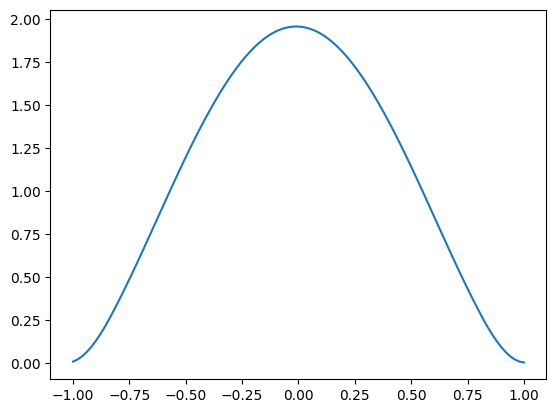

In [15]:
plt.plot(line_param, losses)
plt.show()

## Plot along a direction plane

In [18]:
dir_vec1 = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)
dir_vec2 = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)

In [19]:
x_param = torch.linspace(-1, 1, steps=100)
y_param = torch.linspace(-1, 1, steps=100)
# grid_x, grid_y = torch.meshgrid(x_param, y_param)

In [20]:
losses_3d = []
for x in x_param:
    for y in y_param:
        z = OrderedDict(
            (name, trained_weights[name] + x * dir_vec1[name] + y * dir_vec2[name])
            for name in trained_weights.keys()
        )
        model.load_state_dict(z)
        losses_3d.append(model.loss(model(tr_data[:, :-1]).squeeze(), Y).detach())

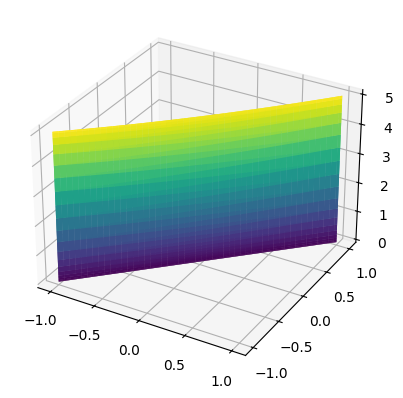

In [21]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(x_param, y_param, torch.tensor(losses_3d).reshape(100, 100), cmap="viridis")
plt.show()

In [22]:
fig = go.Figure(go.Surface(x=x_param, y=y_param, z=torch.tensor(losses_3d).reshape(100, 100)))
fig.update_layout(width=1_200, height=600)
fig.show()